## Step 4: Evaluate expression of the epigenetic memory astrocyte gene signature across cell types in the Allen Brain Cell atlas

Now we'll examine how expression of the epigenetic memory astrocyte signature varies across the cell types in the Allen Brain Cell atlas. 

In [1]:
import os
os.chdir('..') # changing working directory to parent 'EpiMemAstros' directory, adjust as needed
import pandas as pd
from pathlib import Path
import numpy as np
import anndata as ad
from scipy import sparse
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import seaborn as sns

plt.rcParams['font.family'] = 'Arial'
sc.set_figure_params(dpi = 600, dpi_save = 600, vector_friendly = True, format = 'svg')

First, read in the ABC atlas anndata object we saved in the previous step. Note that this AnnData file is nearly 300 GB in size. Depending on your hardware specifications, you may need to load this file in 'backed' mode so that it is not fully loaded into memory. [See the Scanpy documentation for details.](https://scanpy.readthedocs.io/en/stable/generated/scanpy.read_h5ad.html)

In [2]:
mouse_atlas = sc.read_h5ad('outputs/allen_brain_cell_atlas-RAW.h5ad')
mouse_atlas

AnnData object with n_obs × n_vars = 4042976 × 32285
    obs: 'cell_barcode_x', 'library_label_x', 'anatomical_division_label', 'cell_barcode_y', 'barcoded_cell_sample_label', 'library_label_y', 'feature_matrix_label', 'entity', 'brain_section_label', 'library_method', 'region_of_interest_acronym', 'donor_label', 'donor_genotype', 'donor_sex', 'dataset_label', 'x', 'y', 'cluster_alias', 'abc_sample_id', 'neurotransmitter', 'class', 'subclass', 'supertype', 'cluster'
    var: 'gene_symbol', 'name', 'mapped_ncbi_identifier', 'comment'

This large atlas includes clusters defined at highly granular levels. Because we're interested in expression across general cell type categories, we'll next assign cells into broad cell type categories based on their cluster labels.

We'll first examine the broadest cluster classes present in the dataset.

In [3]:
classes = np.unique(mouse_atlas.obs['class'].values)
classes

array(['01 IT-ET Glut', '02 NP-CT-L6b Glut', '03 OB-CR Glut',
       '04 DG-IMN Glut', '05 OB-IMN GABA', '06 CTX-CGE GABA',
       '07 CTX-MGE GABA', '08 CNU-MGE GABA', '09 CNU-LGE GABA',
       '10 LSX GABA', '11 CNU-HYa GABA', '12 HY GABA', '13 CNU-HYa Glut',
       '14 HY Glut', '15 HY Gnrh1 Glut', '16 HY MM Glut', '17 MH-LH Glut',
       '18 TH Glut', '19 MB Glut', '20 MB GABA', '21 MB Dopa',
       '22 MB-HB Sero', '23 P Glut', '24 MY Glut', '25 Pineal Glut',
       '26 P GABA', '27 MY GABA', '28 CB GABA', '29 CB Glut',
       '30 Astro-Epen', '31 OPC-Oligo', '32 OEC', '33 Vascular',
       '34 Immune'], dtype=object)

Neuron are divided among many different cluster classes, but for our purposes we group them into a single cell type group. Let's extract a list of the neuronal cluster classes.

In [4]:
neuron_prefixes = [f"{i:02d}" for i in range(1, 30)]
neuron_classes = [x for x in classes if x.startswith(tuple(neuron_prefixes))]
neuron_classes

['01 IT-ET Glut',
 '02 NP-CT-L6b Glut',
 '03 OB-CR Glut',
 '04 DG-IMN Glut',
 '05 OB-IMN GABA',
 '06 CTX-CGE GABA',
 '07 CTX-MGE GABA',
 '08 CNU-MGE GABA',
 '09 CNU-LGE GABA',
 '10 LSX GABA',
 '11 CNU-HYa GABA',
 '12 HY GABA',
 '13 CNU-HYa Glut',
 '14 HY Glut',
 '15 HY Gnrh1 Glut',
 '16 HY MM Glut',
 '17 MH-LH Glut',
 '18 TH Glut',
 '19 MB Glut',
 '20 MB GABA',
 '21 MB Dopa',
 '22 MB-HB Sero',
 '23 P Glut',
 '24 MY Glut',
 '25 Pineal Glut',
 '26 P GABA',
 '27 MY GABA',
 '28 CB GABA',
 '29 CB Glut']

Next we create a cell-level metadata dataframe and add a category called 'celltype', grouping cell classes into broad cell type categories. Then, we'll add this category into the anndata object's cell metadata.

In [5]:
obs_df = mouse_atlas.obs

obs_df['celltype'] = np.where(obs_df['class'].isin(neuron_classes), "Neuron", "")
obs_df['celltype'] = np.where(obs_df['subclass']=='316 Bergmann NN', "Bergmann glia", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass'].isin(['317 Astro-CB NN', '318 Astro-NT NN',
       '319 Astro-TE NN', '320 Astro-OLF NN']), "Astrocyte", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='321 Astroependymal NN', "Astroependymal", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='322 Tanycyte NN', "Tanycyte", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='323 Ependymal NN', "Ependymal", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='324 Hypendymal NN', "Hypendymal", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='325 CHOR NN', "Choroid plexus", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='326 OPC NN', "OPC", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='327 Oligo NN', "Oligodendrocyte", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='328 OEC NN', "Olfactory epithelial", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='329 ABC NN', "Arachnoid barrier", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='330 VLMC NN', "Vascular leptomeningeal", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='331 Peri NN', "Pericyte", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='332 SMC NN', "Smooth muscle", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='333 Endo NN', "Endothelial", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='334 Microglia NN', "Microglia", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='335 BAM NN', "BAM", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='336 Monocytes NN', "Monocyte", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='337 DC NN', "Dendritic cell", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='338 Lymphoid NN', "Lymphoid", obs_df['celltype'])

mouse_atlas.obs = obs_df

Let's check the total number of cells present in each broad cell type category.

In [6]:
obs_df.celltype.value_counts()

celltype
Neuron                     2957911
Oligodendrocyte             422574
Astrocyte                   299182
OPC                         122605
Endothelial                  88011
Microglia                    86232
Pericyte                     24907
Smooth muscle                14614
Vascular leptomeningeal       9104
BAM                           5626
Bergmann glia                 3321
Ependymal                     3259
Astroependymal                1232
Olfactory epithelial          1132
Tanycyte                      1072
Arachnoid barrier              857
Choroid plexus                 476
Lymphoid                       404
Dendritic cell                 285
Hypendymal                     139
Monocyte                        33
Name: count, dtype: int64

Because the gene signature lists we have from Lee et al are in gene symbol format, we next swap out gene symbols for the Ensembl IDs previously labeling our anndata object .var slot.

In [7]:
mouse_atlas.var['ensembl_id'] = mouse_atlas.var.index
mouse_atlas.var['gene_symbol'] = mouse_atlas.var['gene_symbol'].astype(str)
mouse_atlas.var['original_gene_symbol'] = mouse_atlas.var.gene_symbol
mouse_atlas.var.index = mouse_atlas.var.gene_symbol
mouse_atlas.var_names_make_unique()

Next, normalize and log-transform the count data.

In [8]:
sc.pp.normalize_total(mouse_atlas, target_sum=10000)
sc.pp.log1p(mouse_atlas)

Now, read in the data from Lee et al's Supplementary Table 3. According to the original manuscript and our original correspondence with the authors, Lee et al defined all genes with log2FoldChange > 0 in this table as a part of the epigenetic memory astrocyte 'Up-Signature'. The authors defined all genes with log2FoldChange < 0 in this table as a part of the epigenetic memory astrocyte 'Down-Signature'. 

We next create lists containing the respective signatures.

In [9]:
signature = pd.read_excel('inputs/zenodo/supplementary_tables/41586_2024_7187_MOESM4_ESM.xlsx')
up_signature = np.sort(signature[(signature.log2FoldChange > 0)].gene.values)
down_signature = np.sort(signature[(signature.log2FoldChange < 0)].gene.values)

Now we run the scanpy function score_genes to calculate an enrichment score for the Up- and Down- signature gene sets for each single cell. This function implements the same scoring method described in [Tirosh et al 2016 (PMID: 27124452)](https://pubmed.ncbi.nlm.nih.gov/27124452/), also used by the [Seurat function AddModuleScore](https://satijalab.org/seurat/reference/addmodulescore), which Lee et al used for scoring their gene signatures in the mouse and human single-cell RNA-seq datasets in Figures 4 & 5. 

In [10]:
sc.tl.score_genes(mouse_atlas, gene_list=up_signature, score_name="Up_Signature")
sc.tl.score_genes(mouse_atlas, gene_list=down_signature, score_name="Down_Signature")

       'Gm15922', 'Gm37347', 'Gm43181', 'Gm45222', 'Gm45551', 'Gm48377',
       'Gm49339', 'Gm5641', 'Gm7536', 'Gm8995', 'Gm9794', 'Gm9973', 'H2az1',
       'Rpl15-ps3', 'Rpl28-ps1', 'Rps12-ps3', 'Rps16-ps2', 'Rps23-ps1',
       'Rps7-ps3', 'Rpsa-ps10', 'Tpt1-ps3', 'Ubb-ps'],
      dtype='object')
       'Gm48309', 'Gm50367', 'Gm5512', 'H2aw', 'Magef1', 'Mtarc2', 'Septin4'],
      dtype='object')


Next, we'll calculate the mean and standard deviation of the Up- and Down- signature enrichment scores within each cell type.

In [11]:
rainbow = ["#E8ECFB", "#D5C9E5", "#BEA0CC", "#A779B4", "#92569E", "#6B4F9E", "#5666B6", "#4D82C5", "#4F97BA",
"#58A3AA", "#64AE97", "#7AB779", "#A0BD57", "#C6B844", "#DDA83B", "#E69036", "#E5702F", "#DE4627",
"#C2221F", "#881F19", "#521A13"]

cell_obs = mouse_atlas.obs

means = cell_obs.groupby('celltype')['Up_Signature'].mean()
stds = cell_obs.groupby('celltype')['Up_Signature'].std()

dmeans = cell_obs.groupby('celltype')['Down_Signature'].mean()
dstds = cell_obs.groupby('celltype')['Down_Signature'].std()

means_df = pd.DataFrame({'up':means, 'down':dmeans, 'upstd':stds, 'downstd':dstds})

means_df['sum'] = means_df.up + -1*means_df.down

means_df = means_df.sort_values(by = 'sum')

means_df['color'] = np.flip(rainbow)

sorted_names = means_df.index.values

means_df

up      down     upstd   downstd       sum  \
celltype                                                                    
Bergmann glia            0.017792  0.651164  0.017773  0.036826 -0.633372   
Astrocyte                0.004209  0.629793  0.029057  0.057695 -0.625584   
Astroependymal           0.093887  0.445392  0.038371  0.097861 -0.351505   
OPC                      0.058594  0.339372  0.020330  0.038974 -0.280778   
Olfactory epithelial     0.123657  0.288924  0.037291  0.054082 -0.165267   
Tanycyte                 0.129697  0.260711  0.040128  0.052301 -0.131014   
Neuron                   0.127094  0.188901  0.026583  0.026614 -0.061807   
Oligodendrocyte          0.138334  0.168282  0.021303  0.031374 -0.029949   
Ependymal                0.139165  0.156841  0.025600  0.043049 -0.017676   
Hypendymal               0.169929  0.156066  0.030750  0.030389  0.013862   
Pericyte                 0.181240  0.091179  0.031798  0.030353  0.090061   
Vascular leptomeningeal  0.227238  0.136077  0.051974  0.030344  0.091161   
Endothelial              0.295585  0.066320  0.048524  0.026882  0.229265   
Arachnoid barrier        0.330933  0.094574  0.043470  0.022398  0.236358   
Smooth muscle            0.301728  0.041110  0.055798  0.030584  0.260618   
Choroid plexus           0.350461  0.063813  0.025599  0.021821  0.286648   
Microglia                0.337574  0.028744  0.052681  0.025351  0.308830   
BAM                      0.354581  0.027359  0.054934  0.026248  0.327221   
Lymphoid                 0.338288 -0.003325  0.048602  0.027837  0.341613   
Monocyte                 0.521098  0.015888  0.066572  0.028060  0.505211   
Dendritic cell           0.512489 -0.011341  0.053026  0.021736  0.523829   

                           color  
celltype                          
Bergmann glia            #521A13  
Astrocyte                #881F19  
Astroependymal           #C2221F  
OPC                      #DE4627  
Olfactory epithelial     #E5702F  
Tanycyte                 #E69036  
Neuron                   #DDA83B  
Oligodendrocyte          #C6B844  
Ependymal                #A0BD57  
Hypendymal               #7AB779  
Pericyte                 #64AE97  
Vascular leptomeningeal  #58A3AA  
Endothelial              #4F97BA  
Arachnoid barrier        #4D82C5  
Smooth muscle            #5666B6  
Choroid plexus           #6B4F9E  
Microglia                #92569E  
BAM                      #A779B4  
Lymphoid                 #BEA0CC  
Monocyte                 #D5C9E5  
Dendritic cell           #E8ECFB

Plot those values in a scatter plot: 

/var/folders/s3/tntkzwtx595cbz0665j_z4tc0000gr/T/ipykernel_56119/3350039273.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(x=means_df['down'][idxs[0]], y=means_df['up'][idxs[0]], label = cluster, s = 70, edgecolor='black', linewidth=0.5, color = color)
/var/folders/s3/tntkzwtx595cbz0665j_z4tc0000gr/T/ipykernel_56119/3350039273.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.errorbar(x=means_df['down'][idxs[0]], y=means_df['up'][idxs[0]], xerr=means_df['downstd'][idxs[0]], yerr=means_df['upstd'][idxs[0]], color=color, alpha = 0.7)


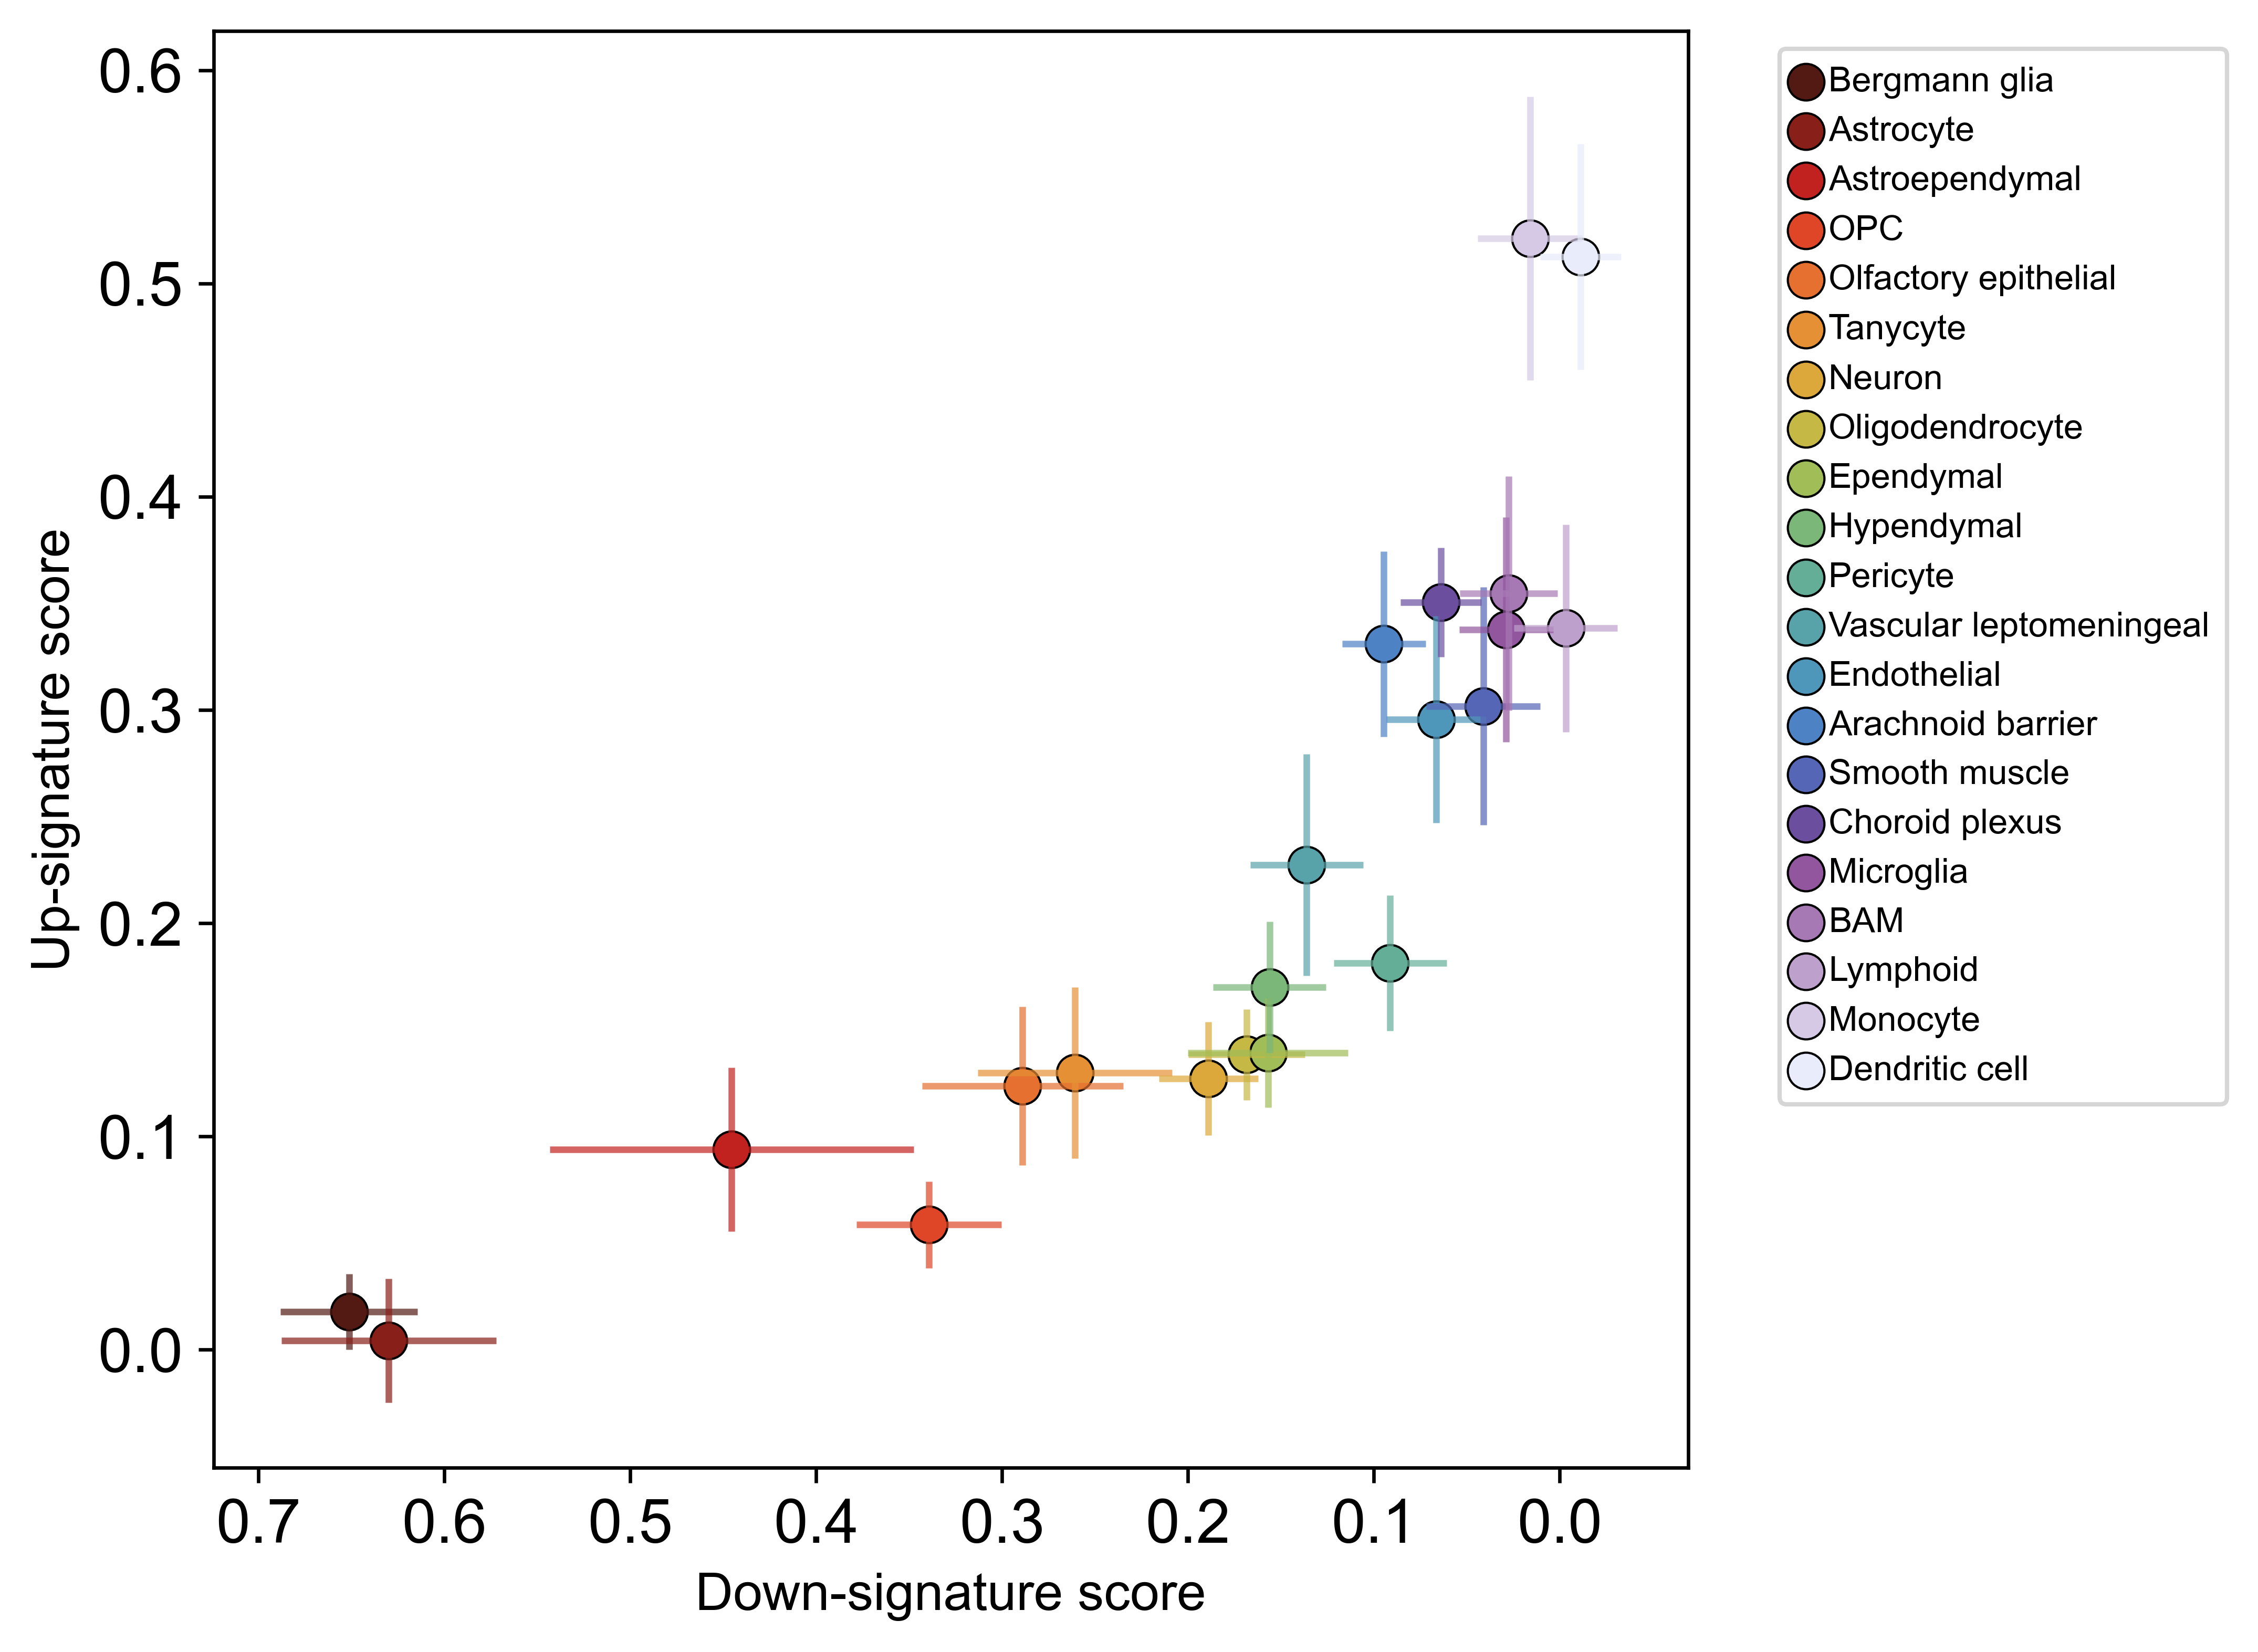

In [12]:
with plt.rc_context({"figure.figsize": (6, 6), "figure.dpi":300}):
    fig, ax = plt.subplots()
    for cluster, color in zip(means_df.index.values, means_df['color'].values):
        idxs = np.where(means_df.index.values == cluster)
        ax.scatter(x=means_df['down'][idxs[0]], y=means_df['up'][idxs[0]], label = cluster, s = 70, edgecolor='black', linewidth=0.5, color = color)
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=8, markerscale=1, borderpad=0.5)
    
    for cluster, color in zip(means_df.index.values, means_df['color'].values):
        idxs = np.where(means_df.index.values == cluster)
        plt.errorbar(x=means_df['down'][idxs[0]], y=means_df['up'][idxs[0]], xerr=means_df['downstd'][idxs[0]], yerr=means_df['upstd'][idxs[0]], color=color, alpha = 0.7)

    ax.invert_xaxis()
    plt.grid(False)
    plt.xlabel('Down-signature score', fontsize=12)
    plt.ylabel('Up-signature score', fontsize=12)
    
    plt.savefig('outputs/figures/figure1d_combination_plot_originalsignature.svg', format='svg', bbox_inches = 'tight')

Create a matching color palette for violin plots:

In [13]:
color_pal = dict(zip(means_df.index.values, means_df.color))

Now we evalute the distribution of enrichment scores across the cell type groups.

First for the Up-Signature: 

/Users/liddelowlab/mambaforge/envs/EpiMemAstros/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:928: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


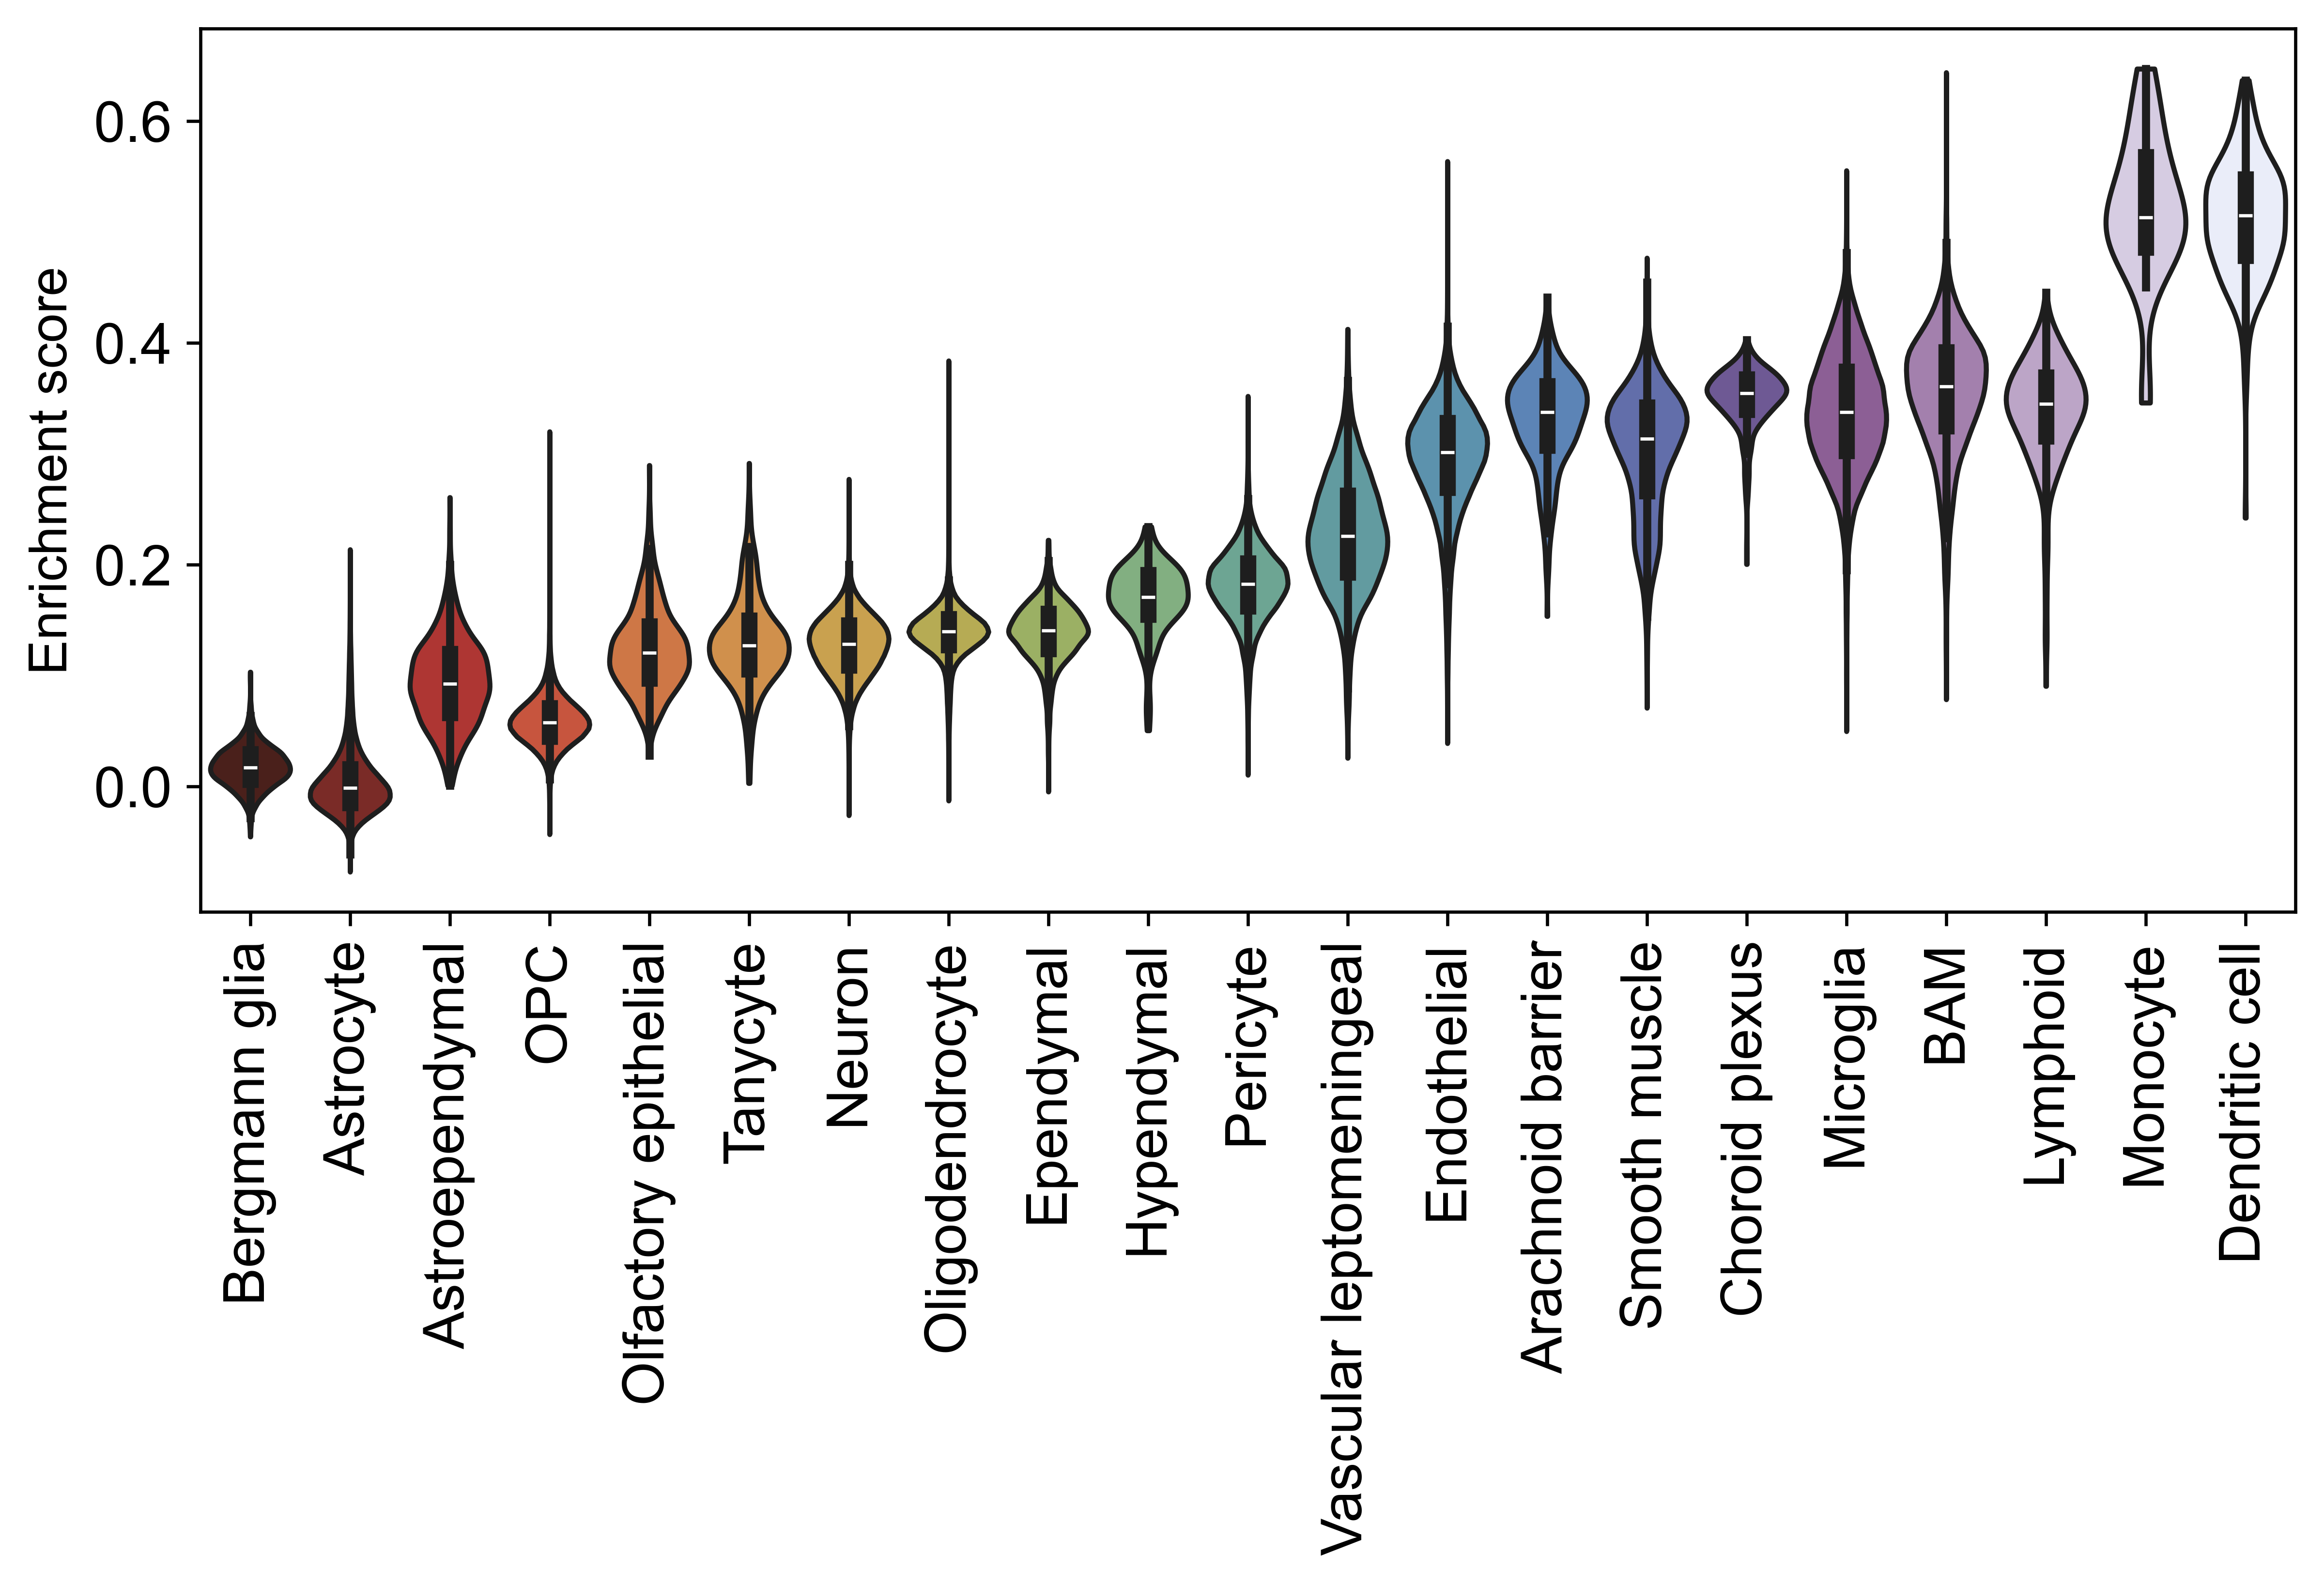

In [14]:
with plt.rc_context({"figure.figsize": (8, 4), "figure.dpi":300}):
    sc.pl.violin(mouse_atlas, keys=['Up_Signature'], groupby="celltype", rotation=90, stripplot = False, inner = 'box', 
                order = means_df.index.values,
                palette = color_pal, show=False, inner_kws=dict(box_width=4, whis_width=2))
    plt.ylabel('Enrichment score', fontsize = 13)
    plt.grid(False)
    plt.savefig('outputs/figures/figure1d_upsignature_originalsignature.svg', format='svg', bbox_inches = 'tight')

And for the Down-Signature:

/Users/liddelowlab/mambaforge/envs/EpiMemAstros/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:928: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


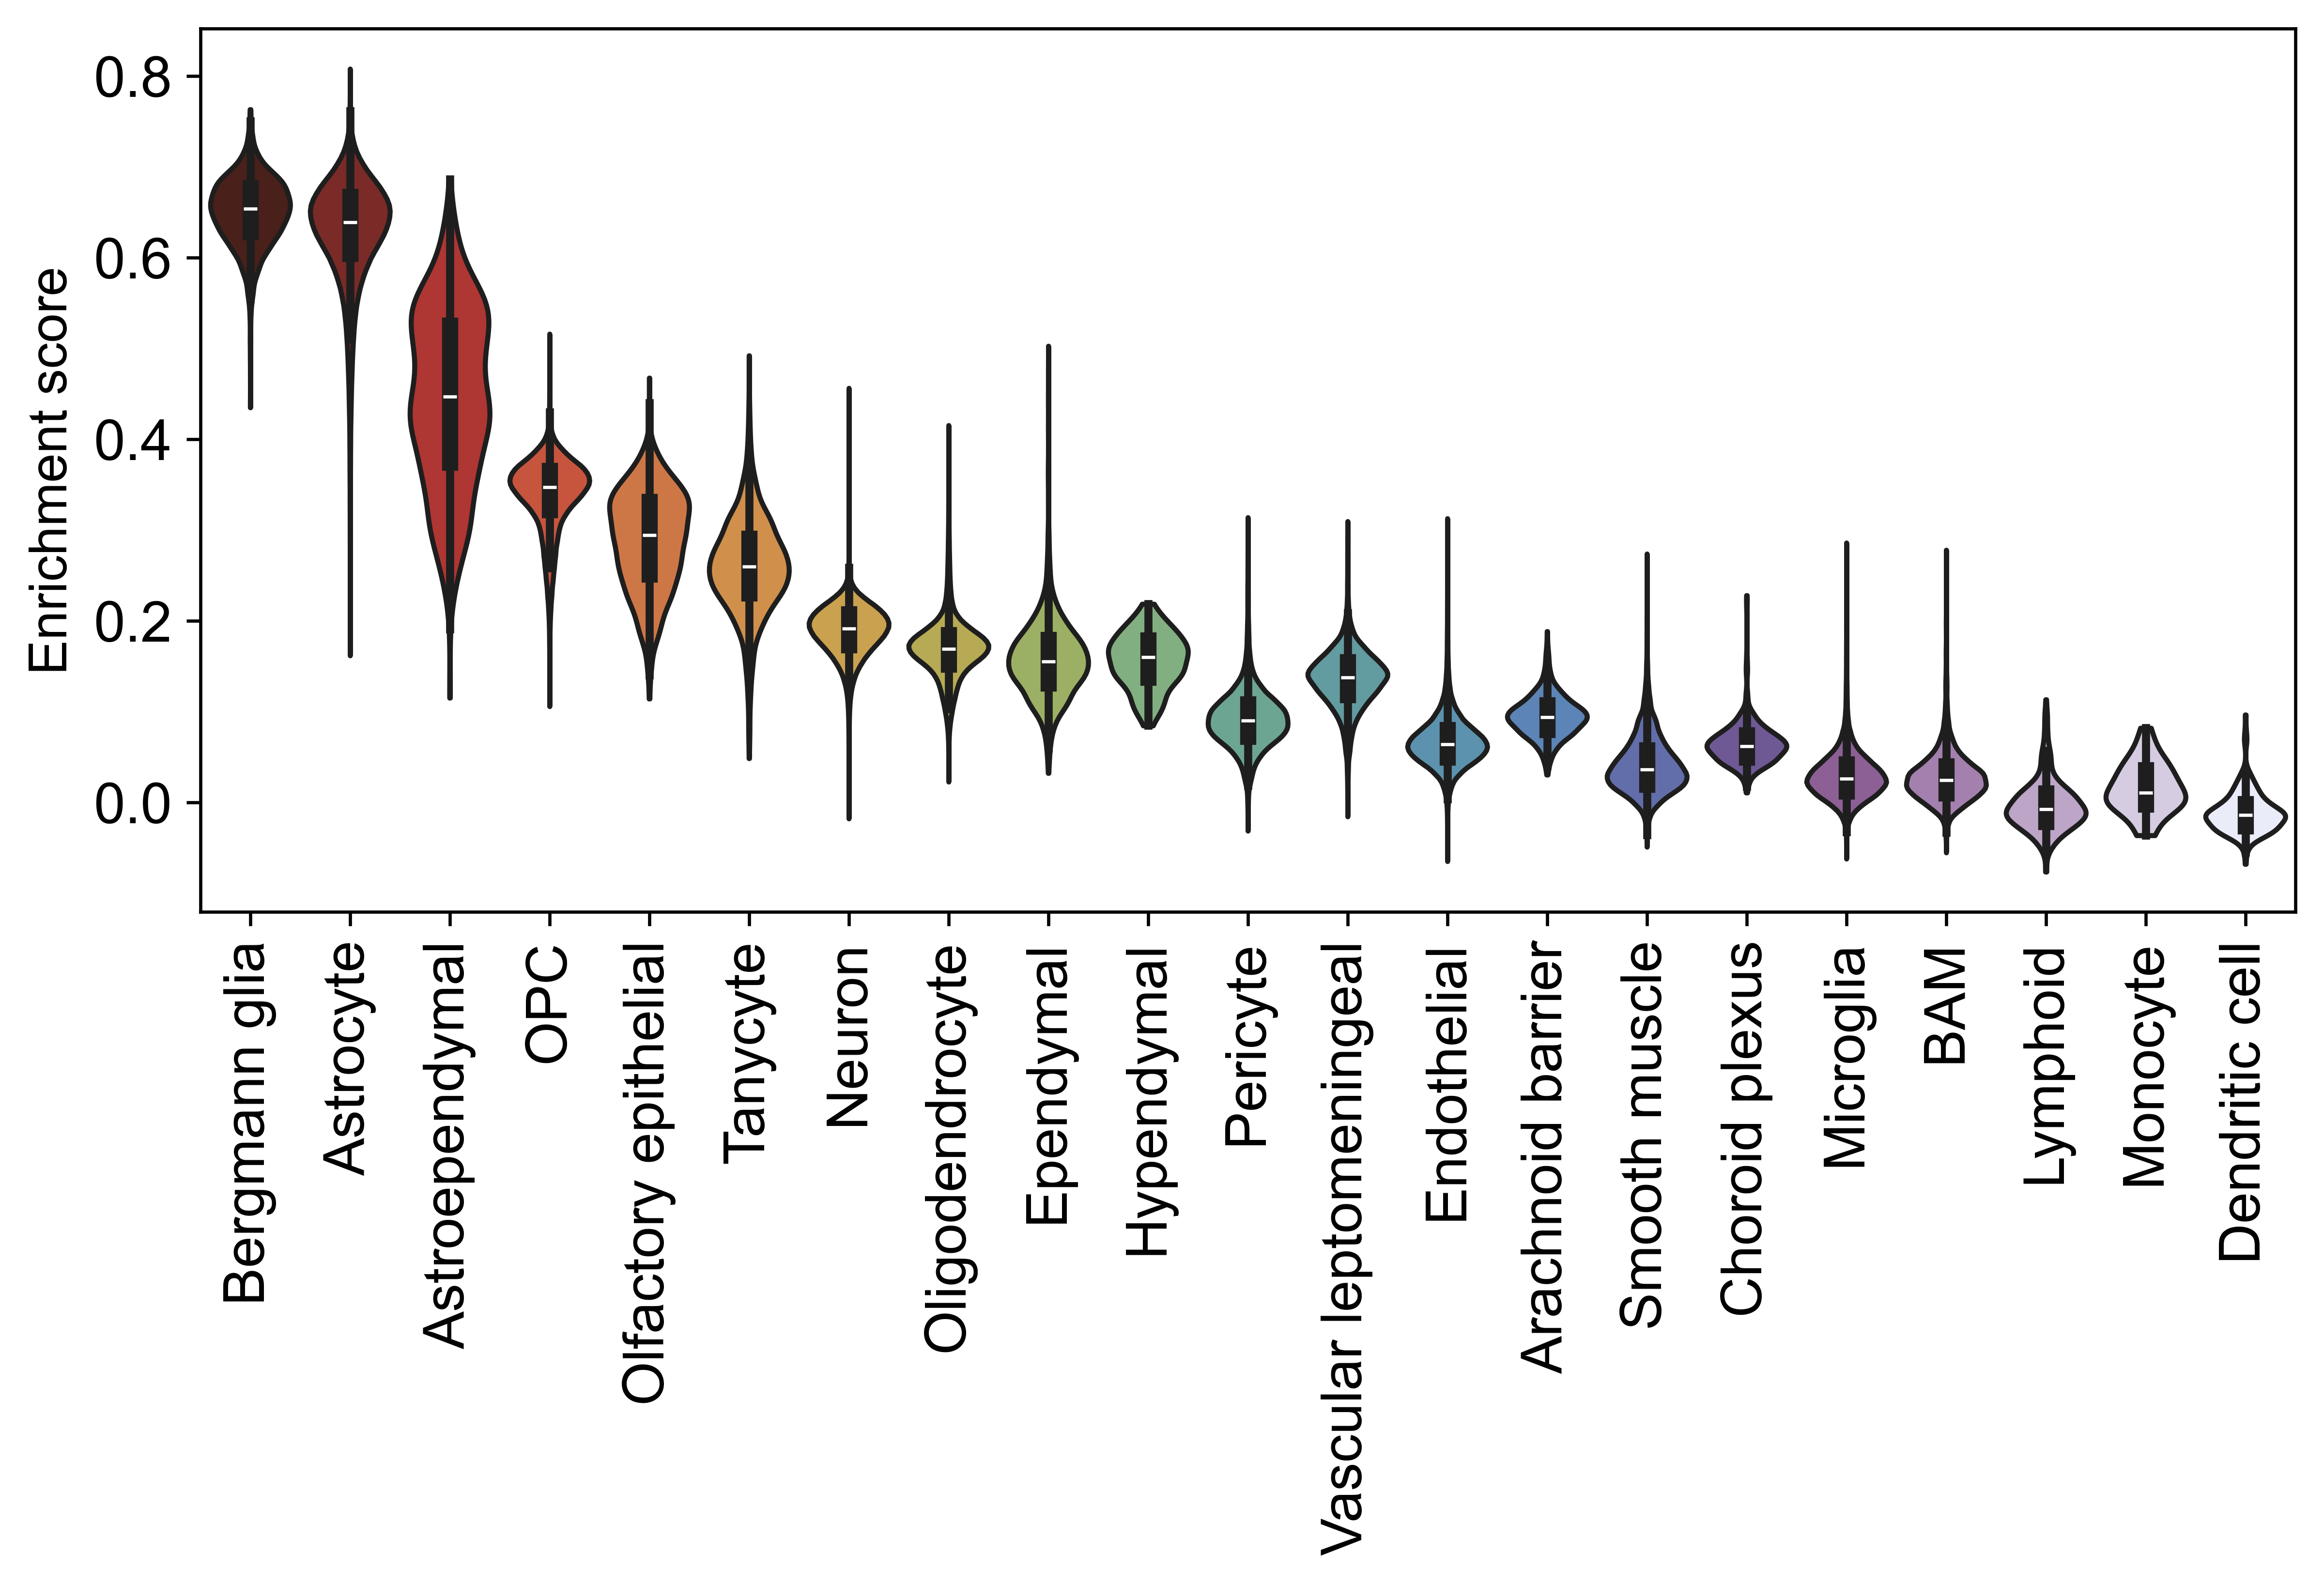

In [15]:
with plt.rc_context({"figure.figsize": (8, 4), "figure.dpi":300}):
    sc.pl.violin(mouse_atlas, keys=['Down_Signature'], groupby="celltype", rotation=90, stripplot = False, inner = 'box',
               order = means_df.index.values,
                palette = color_pal, show=False, inner_kws=dict(box_width=4, whis_width=2))
    plt.ylabel('Enrichment score', fontsize = 13)
    plt.grid(False)
    plt.savefig('outputs/figures/figure1d_downsignature_originalsignature.svg', format='svg', bbox_inches = 'tight')

The Up- and Down-Signature gene sets include many genes which were not statistically significant in differential expression between the two-hit & one-hit cytokine stimulation groups. We discuss the derivation of the gene signatures in more detail in the Step 6 notebook.

Let's evaluate whether the enrichment scores differ if we remove all genes which were non-signficant (adjusted p-value > 0.05):

In [16]:
sig_up_signature = np.sort(signature[(signature.log2FoldChange > 0) & (signature.padj < 0.05)].gene.values)
sig_down_signature = np.sort(signature[(signature.log2FoldChange < 0) & (signature.padj < 0.05)].gene.values)

sc.tl.score_genes(mouse_atlas, gene_list=sig_up_signature, score_name="Sig_Up_Signature")
sc.tl.score_genes(mouse_atlas, gene_list=sig_down_signature, score_name="Sig_Down_Signature")

       'Ubb-ps'],
      dtype='object')


For the Up-Signature, this doesn't much change the pattern of enrichment scores across cell types: 

/Users/liddelowlab/mambaforge/envs/EpiMemAstros/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:928: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


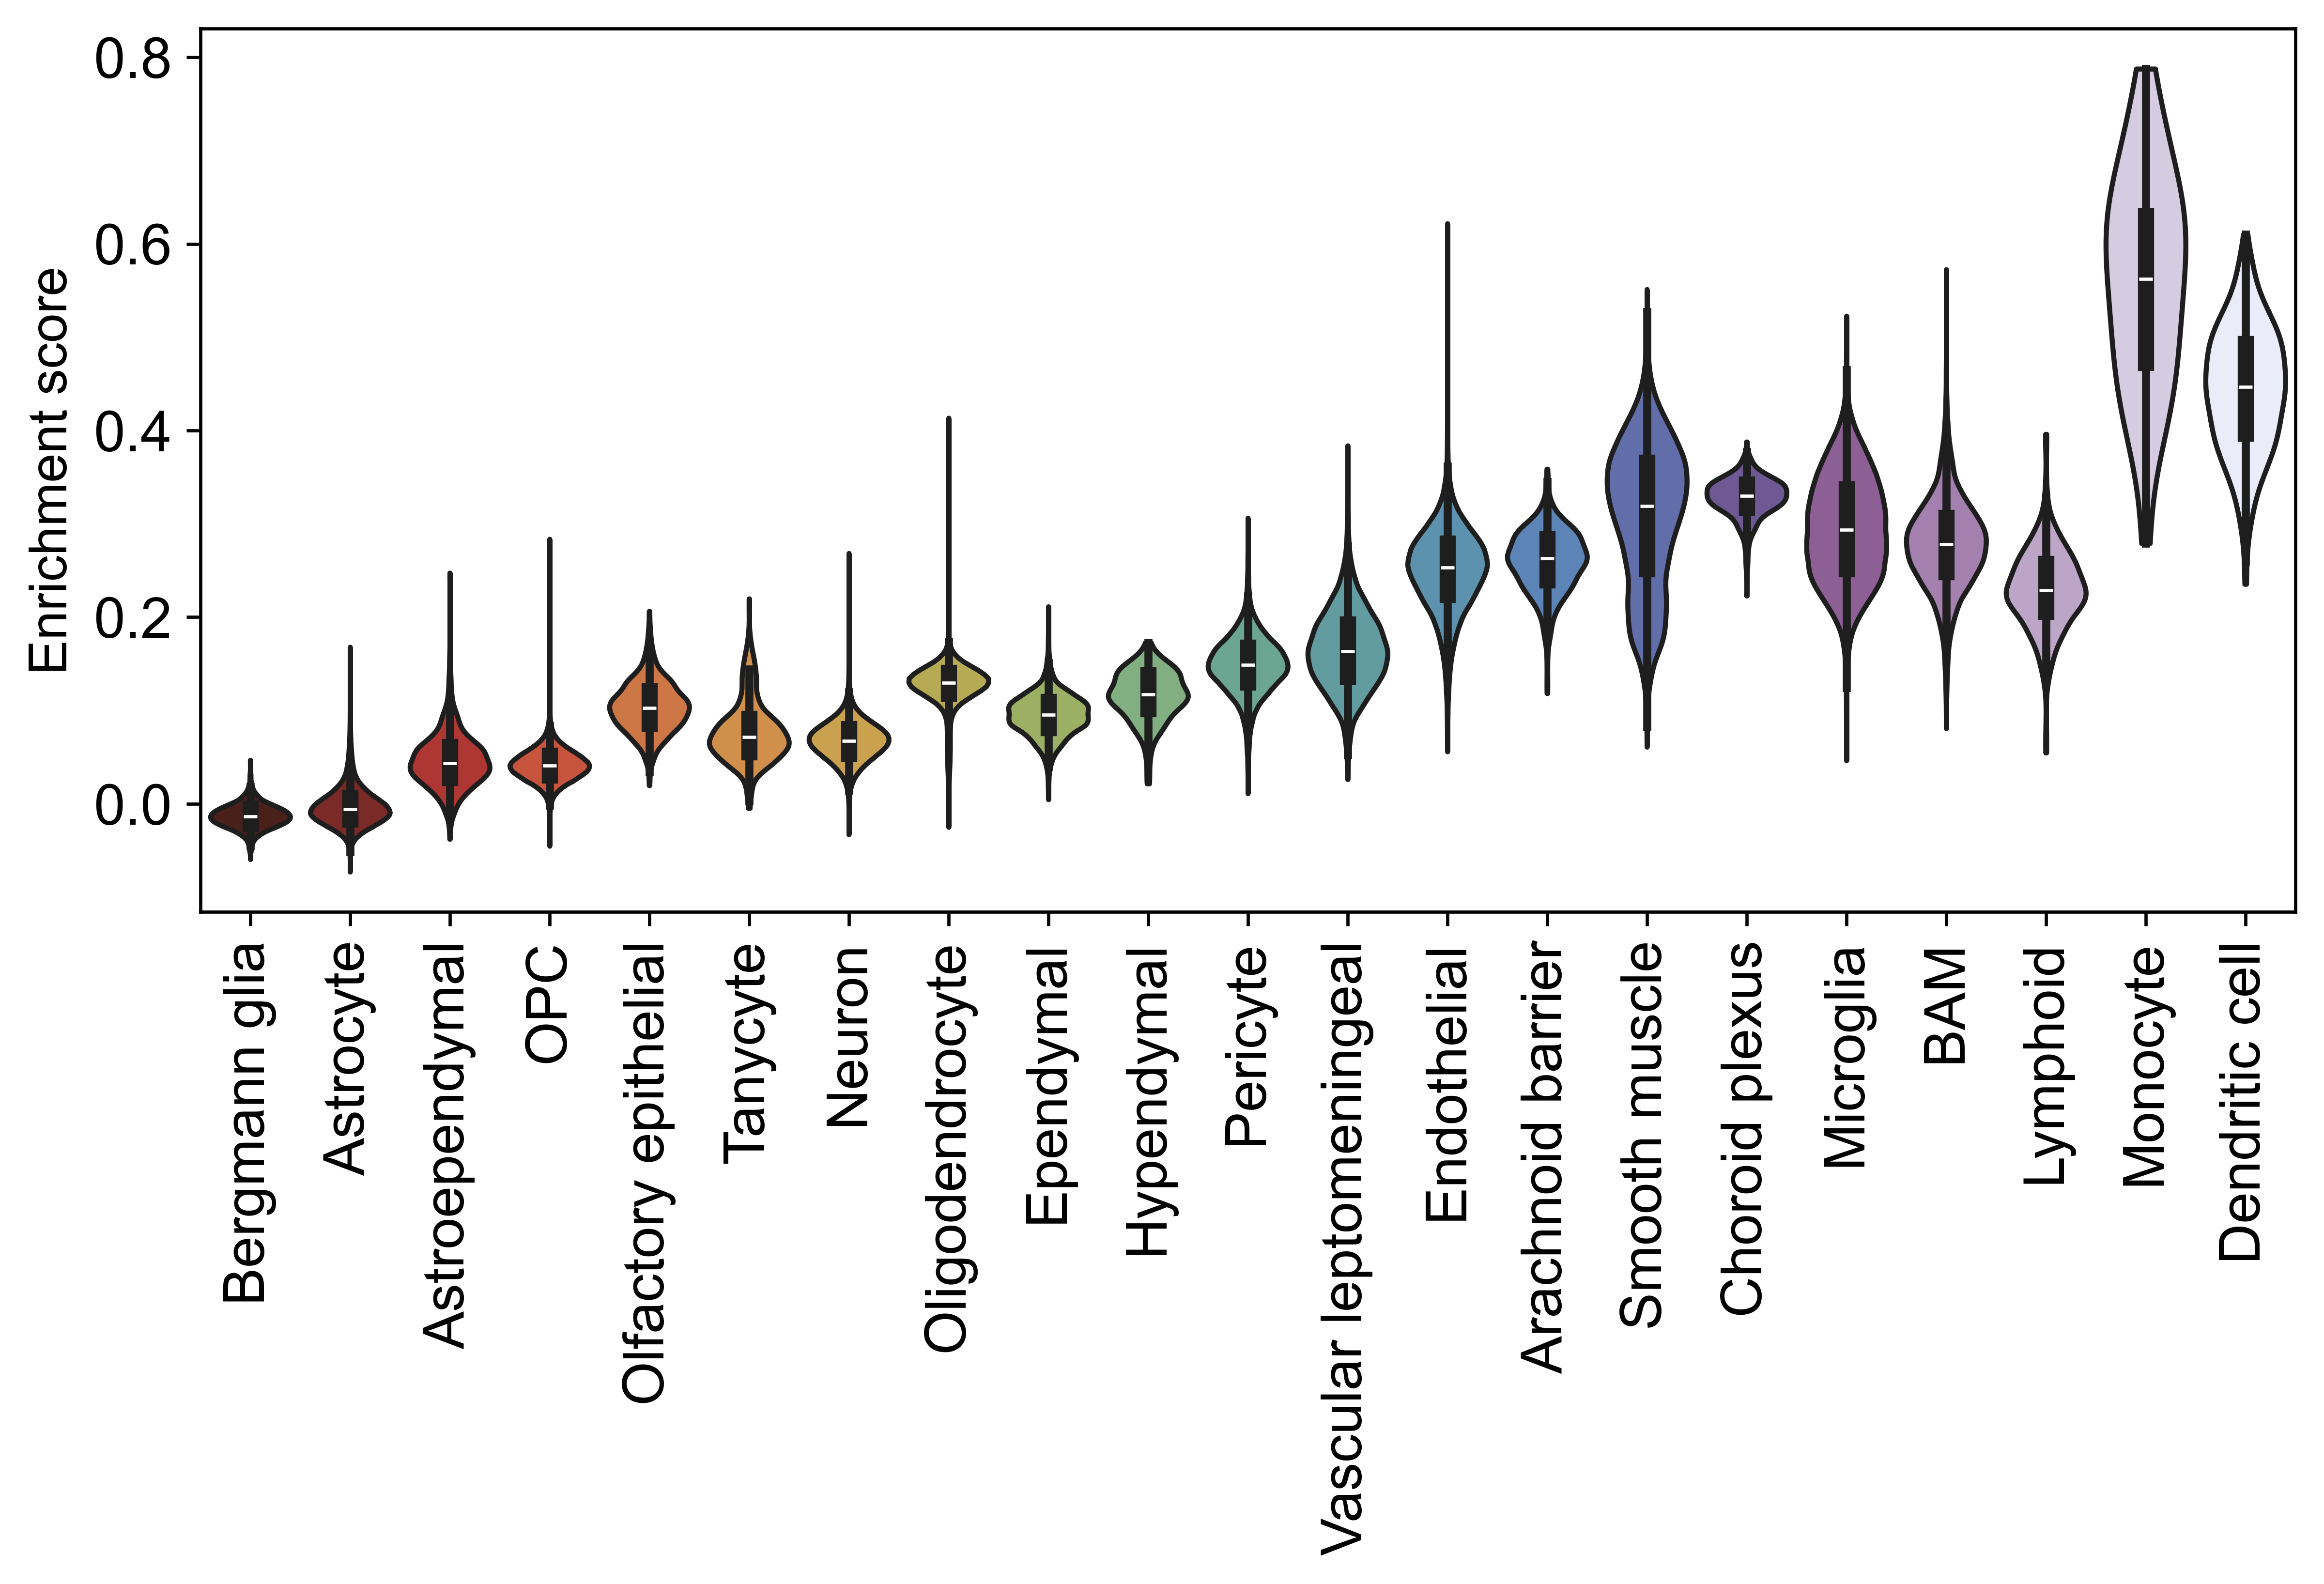

In [17]:
with plt.rc_context({"figure.figsize": (8, 4), "figure.dpi":300}):
    sc.pl.violin(mouse_atlas, keys=['Sig_Up_Signature'], groupby="celltype", rotation=90, stripplot = False, inner = 'box', 
                order = means_df.index.values,
                palette = color_pal, show=False, inner_kws=dict(box_width=4, whis_width=2))
    plt.ylabel('Enrichment score', fontsize = 13)
    plt.grid(False)
    plt.savefig('outputs/figures/figure1d_filtered_upsignature_originalsignature.svg', format='svg', bbox_inches = 'tight')

This seems to hold true for the Down-Signature as well: 

/Users/liddelowlab/mambaforge/envs/EpiMemAstros/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:928: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


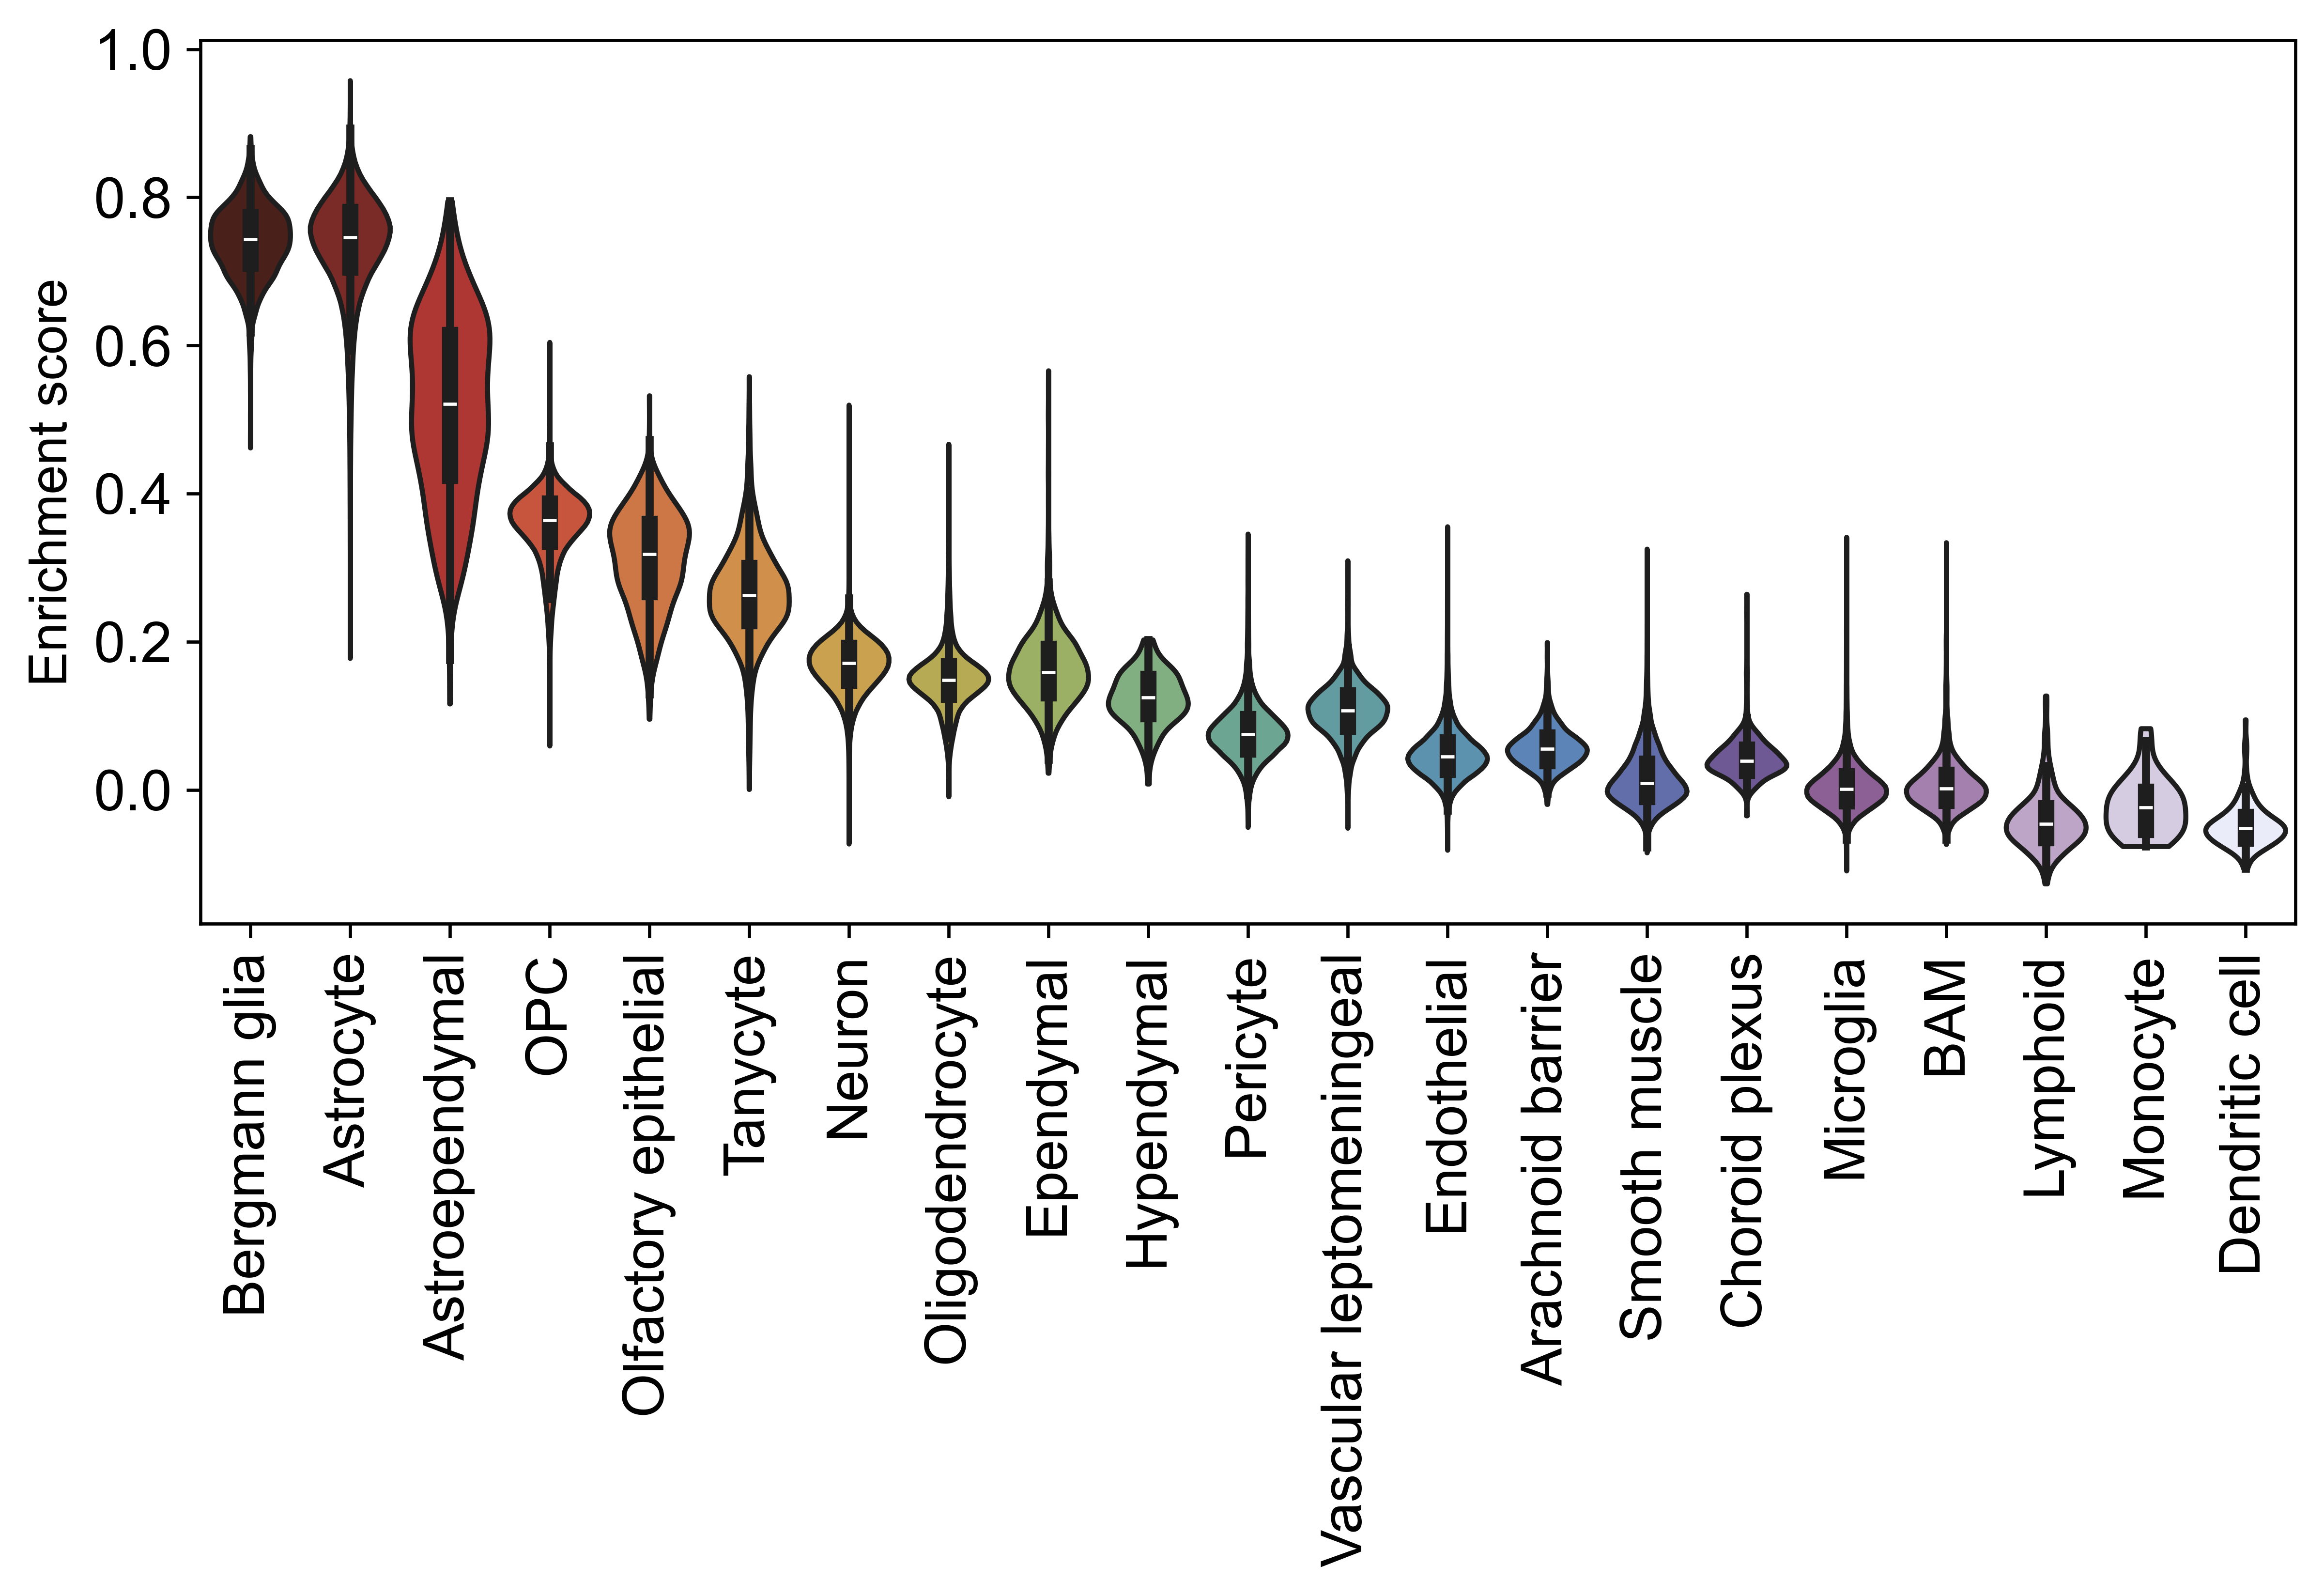

In [18]:
with plt.rc_context({"figure.figsize": (8, 4), "figure.dpi":300}):
    sc.pl.violin(mouse_atlas, keys=['Sig_Down_Signature'], groupby="celltype", rotation=90, stripplot = False, inner = 'box', 
                order = means_df.index.values,
                palette = color_pal, show=False, inner_kws=dict(box_width=4, whis_width=2))
    plt.ylabel('Enrichment score', fontsize = 13)
    plt.grid(False)
    plt.savefig('outputs/figures/figure1d_filtered_downsignature_originalsignature.svg', format='svg', bbox_inches = 'tight')

In [19]:
cell_obs = mouse_atlas.obs
means = cell_obs.groupby('celltype')['Sig_Up_Signature'].mean()
means = means[sorted_names]
stds = cell_obs.groupby('celltype')['Sig_Up_Signature'].std()
stds = stds[sorted_names]
dmeans = cell_obs.groupby('celltype')['Sig_Down_Signature'].mean()
dmeans = dmeans[sorted_names]
dstds = cell_obs.groupby('celltype')['Sig_Down_Signature'].std()
dstds = dstds[sorted_names]
means_df = pd.DataFrame({'up':means, 'down':dmeans, 'upstd':stds, 'downstd':dstds})

means_df['sum'] = means_df.up + -1*means_df.down
means_df['color'] = np.flip(rainbow)

means_df

/var/folders/s3/tntkzwtx595cbz0665j_z4tc0000gr/T/ipykernel_56119/1792224781.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = cell_obs.groupby('celltype')['Sig_Up_Signature'].mean()
/var/folders/s3/tntkzwtx595cbz0665j_z4tc0000gr/T/ipykernel_56119/1792224781.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stds = cell_obs.groupby('celltype')['Sig_Up_Signature'].std()
/var/folders/s3/tntkzwtx595cbz0665j_z4tc0000gr/T/ipykernel_56119/1792224781.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain curr

up      down     upstd   downstd       sum  \
celltype                                                                    
Bergmann glia           -0.013241  0.741049  0.012332  0.046914 -0.754290   
Astrocyte               -0.003762  0.736164  0.019578  0.068668 -0.739926   
Astroependymal           0.045690  0.515445  0.027749  0.123593 -0.469755   
OPC                      0.041120  0.356607  0.016200  0.045203 -0.315488   
Olfactory epithelial     0.103647  0.310694  0.026629  0.065417 -0.207047   
Tanycyte                 0.076920  0.265378  0.032741  0.063237 -0.188457   
Neuron                   0.067188  0.168468  0.020039  0.033690 -0.101280   
Oligodendrocyte          0.126985  0.148503  0.022156  0.038428 -0.021518   
Ependymal                0.094900  0.162542  0.021727  0.052149 -0.067641   
Hypendymal               0.115964  0.123459  0.026429  0.035541 -0.007495   
Pericyte                 0.148489  0.077158  0.029434  0.036390  0.071331   
Vascular leptomeningeal  0.164933  0.106480  0.041653  0.035288  0.058453   
Endothelial              0.250169  0.048214  0.043234  0.033220  0.201956   
Arachnoid barrier        0.260134  0.056813  0.032587  0.026412  0.203321   
Smooth muscle            0.307667  0.015599  0.077188  0.036986  0.292068   
Choroid plexus           0.328617  0.042257  0.020763  0.027302  0.286359   
Microglia                0.294825  0.003762  0.057108  0.030492  0.291063   
BAM                      0.277912  0.005994  0.047712  0.032303  0.271919   
Lymphoid                 0.230033 -0.041677  0.041306  0.037543  0.271710   
Monocyte                 0.561138 -0.022044  0.117164  0.039043  0.583182   
Dendritic cell           0.444534 -0.048614  0.067300  0.027676  0.493148   

                           color  
celltype                          
Bergmann glia            #521A13  
Astrocyte                #881F19  
Astroependymal           #C2221F  
OPC                      #DE4627  
Olfactory epithelial     #E5702F  
Tanycyte                 #E69036  
Neuron                   #DDA83B  
Oligodendrocyte          #C6B844  
Ependymal                #A0BD57  
Hypendymal               #7AB779  
Pericyte                 #64AE97  
Vascular leptomeningeal  #58A3AA  
Endothelial              #4F97BA  
Arachnoid barrier        #4D82C5  
Smooth muscle            #5666B6  
Choroid plexus           #6B4F9E  
Microglia                #92569E  
BAM                      #A779B4  
Lymphoid                 #BEA0CC  
Monocyte                 #D5C9E5  
Dendritic cell           #E8ECFB

/var/folders/s3/tntkzwtx595cbz0665j_z4tc0000gr/T/ipykernel_56119/3132606159.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(x=means_df['down'][idxs[0]], y=means_df['up'][idxs[0]], label = cluster, s = 70, edgecolor='black', linewidth=0.5, color = color)
/var/folders/s3/tntkzwtx595cbz0665j_z4tc0000gr/T/ipykernel_56119/3132606159.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.errorbar(x=means_df['down'][idxs[0]], y=means_df['up'][idxs[0]], xerr=means_df['downstd'][idxs[0]], yerr=means_df['upstd'][idxs[0]], color=color, alpha = 0.5)


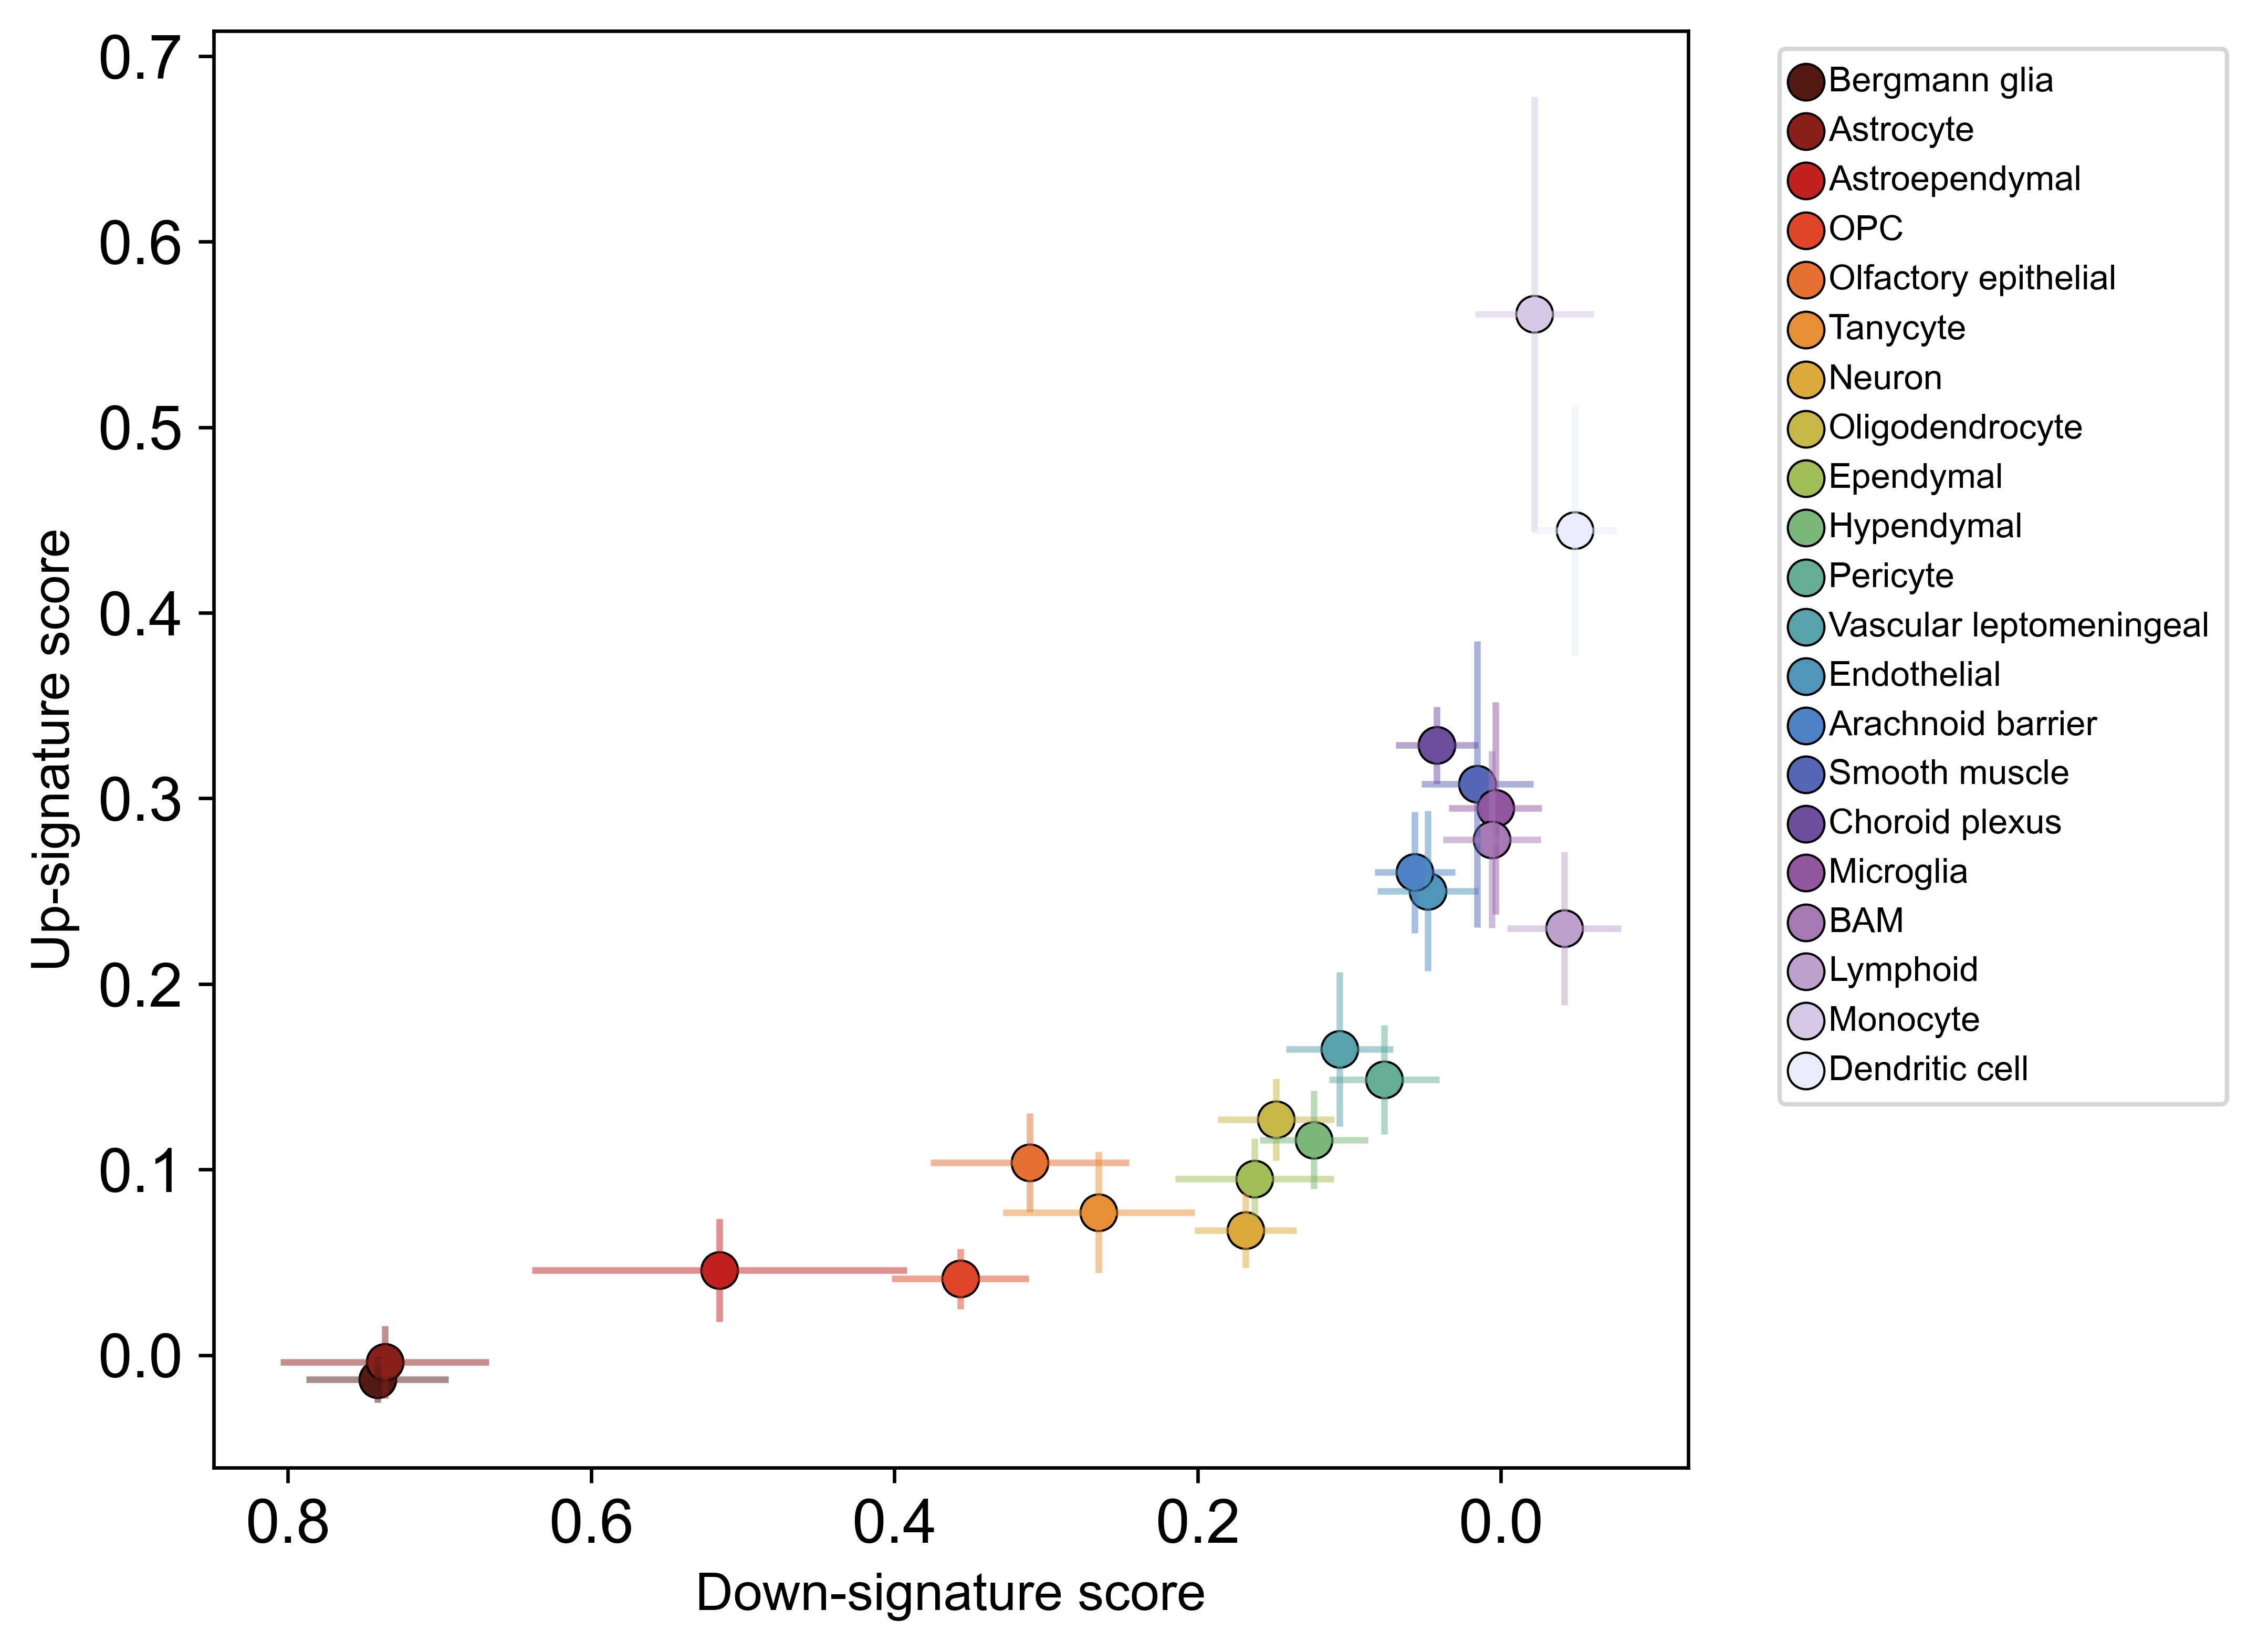

In [20]:
with plt.rc_context({"figure.figsize": (6, 6), "figure.dpi":300}):
    fig, ax = plt.subplots()
    for cluster, color in zip(means_df.index.values, means_df['color'].values):
        idxs = np.where(means_df.index.values == cluster)
        ax.scatter(x=means_df['down'][idxs[0]], y=means_df['up'][idxs[0]], label = cluster, s = 70, edgecolor='black', linewidth=0.5, color = color)
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=8, markerscale=1, borderpad=0.5)
    
    for cluster, color in zip(means_df.index.values, means_df['color'].values):
        idxs = np.where(means_df.index.values == cluster)
        plt.errorbar(x=means_df['down'][idxs[0]], y=means_df['up'][idxs[0]], xerr=means_df['downstd'][idxs[0]], yerr=means_df['upstd'][idxs[0]], color=color, alpha = 0.5)

    ax.invert_xaxis()
    plt.xlabel('Down-signature score', fontsize=12)
    plt.ylabel('Up-signature score', fontsize=12)
    plt.grid(False)
    plt.savefig('outputs/figures/figure1d_combination_plot_filtered_signatures.svg', format='svg', bbox_inches = 'tight')

Now we'll extract matrices containing the average normalized expression within each cell type class for the up-signature genes and down-signature genes, and save these as CSV files. We'll use these for plotting heatmaps in Step 5.

In [21]:
avg_ad = sc.get.aggregate(mouse_atlas, by = "celltype", func="mean")
avg_exp = pd.DataFrame(avg_ad.layers['mean'].T, index = avg_ad.var_names, columns = avg_ad.obs_names)

up_signature_avg_exp = avg_exp[avg_exp.index.isin(up_signature)]
up_signature_avg_exp.to_csv("outputs/mouse_atlas_up_signature_avg_expression_dataframe.csv")

down_signature_avg_exp = avg_exp[avg_exp.index.isin(down_signature)]
down_signature_avg_exp.to_csv("outputs/mouse_atlas_down_signature_avg_expression_dataframe.csv")